# Turing Target Practice

## Model

In [68]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [69]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [70]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [71]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [110]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [111]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [112]:
target = TuringTarget(stat_model; compute_MAP=true);

In [113]:
spl = MCHMC(varE_wanted=1.0) #MCHMC(0.03125, 0.6145; varE_wanted=2.0)

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 1.0, 0, 1000, 10, "LF"), Hyperparameters(0.0, 0.0, 0.0, 0.1931833275037836, [0.0]), MicroCanonicalHMC.Leapfrog)

In [114]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true);

eps: 0.5 --> VarE: 0.8236801135805937
samples: 100--> ESS: 0.09052989225706194
samples: 243--> ESS: 0.09508674296686087


[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.45043479852954693, 0.06088870443747615] ✅
[ Info: Tuning eps ⏳
[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 2.103342629683961 ✅


In [115]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

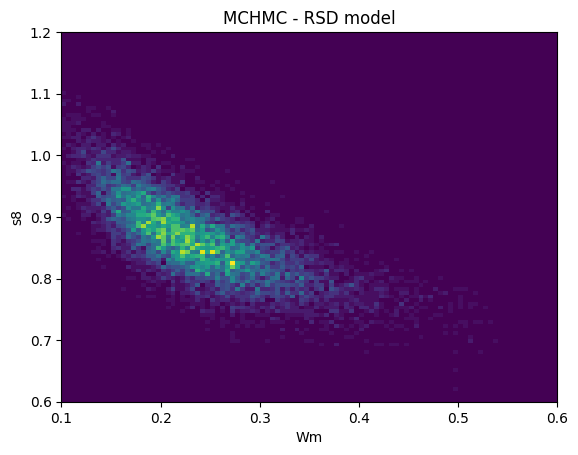

In [116]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [117]:
nchains = 100
e_spl = MCHMC(0.03125, 0.6145, nchains; sigma=[1.0, 1.0])

MicroCanonicalHMC.EnsembleSampler(MicroCanonicalHMC.EnsembleSettings(100, Random.MersenneTwister(0), 0.2, 0, 6, 10, "LF"), Hyperparameters(0.03125, 0.6145, 0.0, 0.1931833275037836, [1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [121]:
samples_ensemble_mchmc = Sample(e_spl, target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

[ Info: Using given hyperparameters
[ Info: Found eps: 0.03125 ✅
[ Info: Found L: 0.6145 ✅


In [122]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

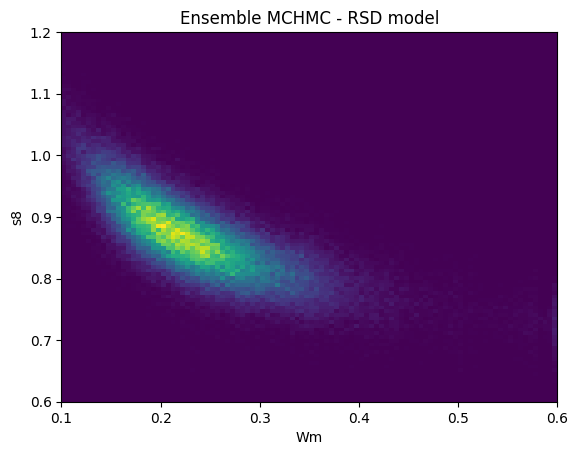

In [123]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

## AbstractMCMC

In [16]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mFloat64[39m[0m to an object of type 
[0m  [91mAbstractVector[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Factorization[39m) where T<:AbstractArray
[0m[90m   @[39m [36mLinearAlgebra[39m [90m~/julia_envs/julia-1.9.0-beta3/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4mfactorization.jl:59[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T<:AbstractArray
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:16[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:64[24m[39m


In [17]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

LoadError: UndefVarError: `samples` not defined

## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mFloat64[39m[0m to an object of type 
[0m  [91mAbstractVector[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Factorization[39m) where T<:AbstractArray
[0m[90m   @[39m [36mLinearAlgebra[39m [90m~/julia_envs/julia-1.9.0-beta3/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4mfactorization.jl:59[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T<:AbstractArray
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:16[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:64[24m[39m


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

LoadError: UndefVarError: `samples` not defined

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.3 seconds
Compute duration  = 11.3 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2423    0.0711     0.0007    0.0016   1552.2530    1.0006    ⋯
          σ8    0.8632    0.0627     0.0006    0.0013   2323.7172    1.0005    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.185213  0.924595  15.62     7.0  1.0  …  2.0  0.0  0.0456212  0.0456212
 0.215057  0.918154  15.3538  15.0  1.0     3.0  0.0  0.0456212  0.0456212
 0.331182  0.785462  15.0301  31.0  1.0     4.0  0.0  0.0456212  0.0456212
 0.331613  0.811651  15.1377  15.0  1.0     4.0  0.0  0.0456212  0.0456212
 0.330636  0.814457  15.1348   3.0  1.0     2.0  0.0  0.0456212  0.0456212
 0.293768  0.824172  15.6628  11.0  1.0  …  3.0  0.0  0.0456212  0.0456212
 0.293768  0.824172  15.6628   3.0  1.0     1.0  0.0  0.0456212  0.0456212
 0.226689  0.863064  16.0813  15.0  1.0     3.0  0.0  0.0456212  0.0456212
 0.218329  0.907994  15.5756   7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

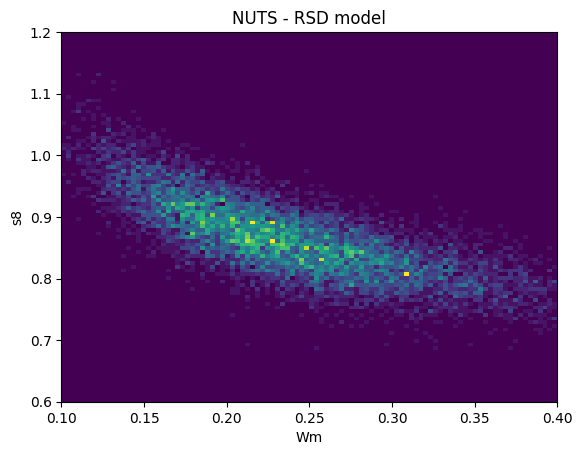

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");